- suggestion

- fit 3 models: 
- univariable
- multi w/ mortagage rate (Endogenous), var(p)
- multi w/ motagage rate (Exogenous) and unemployment rate (Exogenous), sarimax

In [2]:
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import sklearn.metrics as skmetrics
import warnings
from statsmodels.tsa.stattools import arma_order_select_ic
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import pmdarima as pm

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

warnings.filterwarnings("ignore")

In [3]:
series = pd.read_csv('zillow-carlifornia.csv',header=0, index_col=0, parse_dates=True, squeeze=True)
series = series.iloc[:-12,:]
series = series.rename(columns={'MedianSoldPrice_AllHomes.California':'MedianSoldPrice_AllHomes_California'})
series

,MedianSoldPrice_AllHomes_California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2
...,...,...,...
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0


In [4]:
series_target = series[['MedianSoldPrice_AllHomes_California']].copy()
series_target

,MedianSoldPrice_AllHomes_California
Date,
2008-02-29,470000.0
2008-03-31,441000.0
2008-04-30,460000.0
2008-05-31,429000.0
2008-06-30,437500.0
...,...
2015-08-31,475000.0
2015-09-30,470000.0
2015-10-31,470000.0


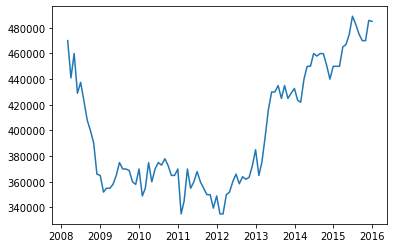

In [5]:
from matplotlib import pyplot
pyplot.plot(series_target)
pyplot.show()

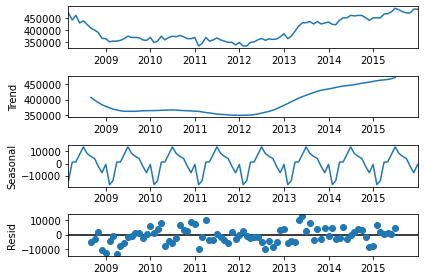

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(series_target, model='addictive',freq=12)
result.plot()
plt.show()

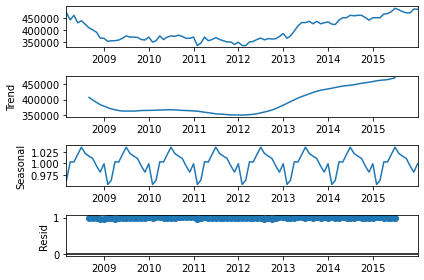

In [82]:
result = seasonal_decompose(series_target, model='multiplicative',freq=12)
result.plot()
plt.show()

In [63]:
# define all the functions we will need 

# trend and seasonal differencing
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff
#trend differencing once: interval=1
#trend differencing twice: d1=diff(data, interval=1); d2=diff(d1 interval=1)
#seasonal differencing: interval=m

#Define ADF test
#Perform from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#[OPTIONAL]grid order search based on BIC
#auto-arima order selection in pmdarima
#if the function doesn't work, you can write one yourself: 

def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for Q in Q_values:
                        order=(p,d,q)
                        seasonal_order=(P,D,Q,m)
#                         try:
                        res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                        bic=res.bic
                        if bic < best_score:
                            best_score, best_order, best_seasonal_order=bic, order,seasonal_order
#                         except:
#                             continue
    print((best_score, best_order, best_seasonal_order))
    

# define evaluation metrics for model selection based on one-step forward cross validation
def evaluate_sarima_model(X, trend_order, seasonal_order):
    train_size = int(len(X) * 0.67)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = np.mean(np.abs(test-predictions)/test)
    return rmse, mae, mape

def evaluate_sarima_model_80(X, trend_order, seasonal_order):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
#     mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
#     mape = np.mean(np.abs(test-predictions)/test)
    return rmse

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -3.088139
p-value                         0.027443
#Lags Used                     11.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


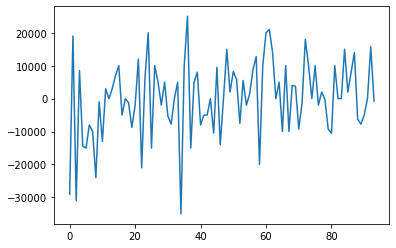

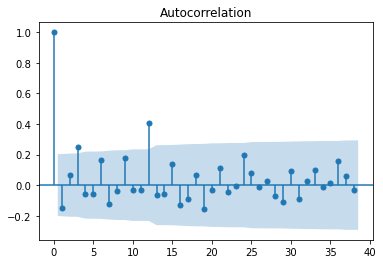

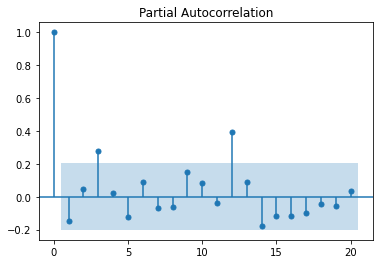

In [92]:
# fit a trend only model d=1
d1 = diff(series_target.MedianSoldPrice_AllHomes_California, 1)
adf_test(d1)
plt.plot(d1)
plot_acf(d1,lags=38) 
plt.show()
plot_pacf(d1,lags=20) 
plt.show()

Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.390432e+00
p-value                        8.027576e-11
#Lags Used                     1.000000e+01
Number of Observations Used    8.200000e+01
Critical Value (1%)           -3.512738e+00
Critical Value (5%)           -2.897490e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


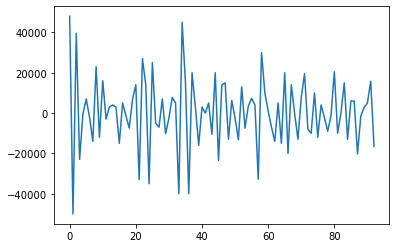

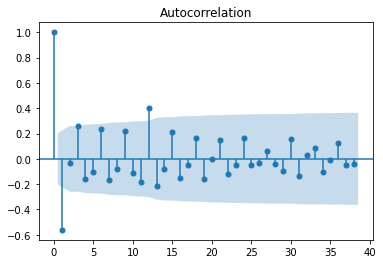

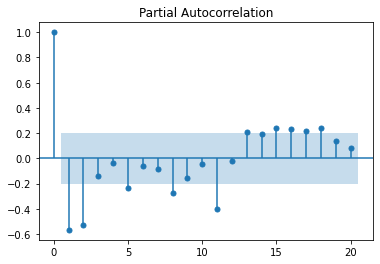

In [93]:
# fit a trend only model d=2
d2 = diff(d1, 1)
adf_test(d2)
plt.plot(d2)
plot_acf(d2,lags=38) 
plt.show()
plot_pacf(d2,lags=20) 
plt.show()

In [94]:
arma_order_select_ic(d1,max_ar=4, max_ma=4, ic='bic')

{'bic':              0            1            2            3            4
 0  2033.963390  2036.631456  2038.201996  2038.727602  2042.965276
 1  2036.256549  2041.742346  2045.028803  2043.015434  2046.380362
 2  2040.525759  2044.825265  2049.910411  2043.252820  2050.044835
 3  2037.595601  2042.138387  2058.399309  2045.331430  2058.778148
 4  2042.137814  2047.149872          NaN          NaN          NaN,
 'bic_min_order': (0, 0)}

In [95]:
arma_order_select_ic(d2,max_ar=4, max_ma=4, ic='bic')

{'bic':              0            1            2            3            4
 0  2087.961822  2016.294028  2016.841843  2019.669593  2021.355711
 1  2053.268684  2016.484131  2023.931164  2025.907583  2025.332262
 2  2027.415477  2020.979058  2024.497709  2019.411019  2023.938431
 3  2029.951875  2033.511225  2024.738814          NaN          NaN
 4  2034.266556  2024.635002  2027.482973          NaN          NaN,
 'bic_min_order': (0, 1)}

In [96]:
bic_sarima(series_target.MedianSoldPrice_AllHomes_California, p_values=range(4),d_values=range(3),q_values=range(4),
           P_values=range(3),Q_values=range(3),m=12, D=1)

(16.029332740929885, (0, 2, 1), (0, 1, 2, 12))


In [98]:
rmse_sarima1 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 1, 0), (0, 0, 0, 0))
rmse_sarima2 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 2, 1), (0, 0, 0, 0))
rmse_sarima3 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 2, 1), (0, 1, 2, 12))

rmse_sarima1, rmse_sarima2, rmse_sarima3

100%|██████████| 19/19 [00:02<00:00,  7.89it/s]


(8161.607813737632, 10323.72403990903, 12598.932484051415)

In [53]:
series_prophet = series_target.copy()
series_prophet.reset_index(inplace=True)
series_prophet = series_prophet.rename(columns={'Date':'ds','MedianSoldPrice_AllHomes_California':'y'})

train_size = int(len(series_prophet) * 0.8)
series_prophet_train, series_prophet_test = series_prophet[0:train_size], series_prophet[train_size:]

In [54]:
model_prophet=Prophet()
model_prophet.fit(series_prophet_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [55]:
future = model_prophet.make_future_dataframe(periods=len(series_prophet_test))
forecast = model_prophet.predict(future)

In [56]:
print(series_prophet_test.shape)
print(series_prophet_train.shape)
print(forecast.shape)
print(forecast.head())

(19, 2)
(76, 2)
(95, 16)
          ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 2008-02-29  461372.970130  445029.575358  462278.717177  461372.970130   
1 2008-03-31  452481.490747  433654.456812  450875.673440  452481.490747   
2 2008-04-30  443876.833279  442345.821204  458741.642933  443876.833279   
3 2008-05-31  434985.353894  429531.468176  446190.519002  434985.353894   
4 2008-06-30  426380.696424  427991.704491  445621.646531  426380.696424   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  461372.970130    -7591.742431          -7591.742431          -7591.742431   
1  452481.490747   -10087.754116         -10087.754116         -10087.754116   
2  443876.833279     6695.934794           6695.934794           6695.934794   
3  434985.353894     2957.676067           2957.676067           2957.676067   
4  426380.696424    10716.647228          10716.647228          10716.647228   

         yearly  yearly_lower  yearly

In [57]:
pred = [forecast["yhat"][76:], series_prophet_test.ds]
headers = ["y", "ds"]
pred = pd.concat(pred, axis=1, keys=headers)
pred.head()

,y,ds
76,461036.085763,2014-06-30
77,462027.666789,2014-07-31
78,463567.915155,2014-08-31
79,465569.909695,2014-09-30
80,467939.008944,2014-10-31


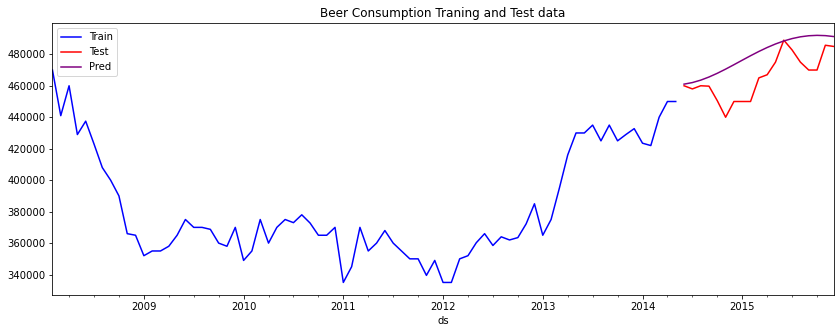

In [58]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
series_prophet_train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
series_prophet_test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
pred.plot(kind='line', x='ds', y='y', color='purple', label='Pred', ax=ax)
plt.title('Beer Consumption Traning and Test data')
plt.show()

In [99]:
rmse_prophet = np.sqrt(skmetrics.mean_squared_error(series_prophet_test.y, pred.y))
rmse_prophet

16936.787904798177

In [100]:
# rmse_sarima1 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 1, 0), (0, 0, 0, 0))
# rmse_sarima2 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 2, 1), (0, 0, 0, 0))
# rmse_sarima3 = evaluate_sarima_model_80(series_target.MedianSoldPrice_AllHomes_California, (0, 2, 1), (0, 1, 2, 12))

rmse_sarima1, rmse_sarima2, rmse_sarima3

(8161.607813737632, 10323.72403990903, 12598.932484051415)

In [70]:
# ARIMA(0, 1, 0) performs best so far

In [107]:
test = pd.read_csv('test.csv',header=0, index_col=0, parse_dates=True, squeeze=True)
# test = test.rename(columns={'MedianSoldPrice_AllHomes.California':'MedianSoldPrice_AllHomes_California'})
test

Month
2016-01-31    476250
2016-02-29    466000
2016-03-31    485000
2016-04-30    501000
2016-05-31    501000
2016-06-30    505000
2016-07-31    507000
2016-08-31    510000
2016-09-30    510000
2016-10-31    523000
2016-11-30    506000
2016-12-31    510000
Name: Median House Price, dtype: int64

In [ ]:
(0, 2, 1), (0, 1, 2, 12)

In [138]:
mod = sm.tsa.statespace.SARIMAX(series_target.MedianSoldPrice_AllHomes_California,
                                order=(0,1,0),seasonal_order=(0,0,0,0))
res = mod.fit()
pred = res.predict(start=len(series_target), end=len(series_target)+11)

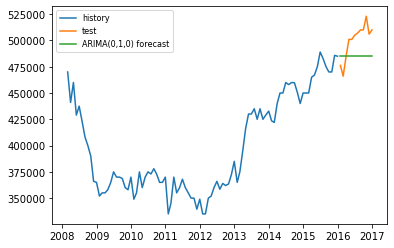

In [139]:
plt.plot(series_target.MedianSoldPrice_AllHomes_California, label='history')
plt.plot(test, label='test')
plt.plot(pred, label='ARIMA(0,1,0) forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [140]:
rmse_final = np.sqrt(skmetrics.mean_squared_error(test, pred))
rmse_final

21590.048826562048

In [153]:
X = pd.concat([series_target.MedianSoldPrice_AllHomes_California, test])

train_size = len(series_target.MedianSoldPrice_AllHomes_California)
train, test = X[0:train_size], X[train_size:]

predictions = list()
for t in tqdm(range(len(test))):
    model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=(0,1,0),seasonal_order=(0,0,0,0)) #rolling forward for one step at each time
    model_fit = model.fit()
    yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
    predictions.append(yhat) #store prediction

predictions_1step = pd.Series(predictions, index=test.index)

100%|██████████| 12/12 [00:00<00:00, 58.64it/s]


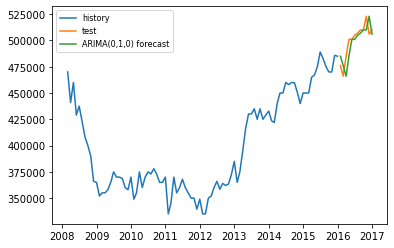

In [154]:
plt.plot(series_target.MedianSoldPrice_AllHomes_California, label='history')
plt.plot(test, label='test')
plt.plot(predictions_1step, label='ARIMA(0,1,0) forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

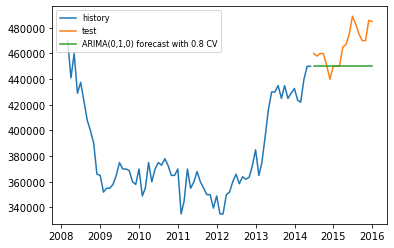

In [13]:
# 0.8 CV instead of one-step CV for ARIMA(0, 1, 0)
split = int(len(series_target.MedianSoldPrice_AllHomes_California)* 0.8)
train= series_target.MedianSoldPrice_AllHomes_California[0:split] 
test_1=series_target.MedianSoldPrice_AllHomes_California[split:]

mod = sm.tsa.statespace.SARIMAX(train,order=(0,1,0),seasonal_order=(0,0,0,0))
res = mod.fit()
pred = res.predict(start=len(train), end=len(train)+len(test_1)-1)

rmse_1 = np.sqrt(skmetrics.mean_squared_error(test_1, pred))

plt.plot(train, label='history')
plt.plot(test_1, label='test')
plt.plot(pred, label='ARIMA(0,1,0) forecast with 0.8 CV')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [14]:
rmse_1

20672.81140964981

In [15]:
# One step CV
X = series_target.MedianSoldPrice_AllHomes_California
train_size = int(len(X) * 0.8)
train, test = X[0:train_size], X[train_size:]

predictions = list()
for t in tqdm(range(len(test))):
    model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=(0,1,0),seasonal_order=(0,0,0,0))
    model_fit = model.fit()
    yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
    predictions.append(yhat) #store prediction
    # calculate out of sample error
predictions = np.asarray(predictions).reshape(-1,)

predictions_1step = pd.Series(predictions, index=test.index)

rmse_1 = np.sqrt(skmetrics.mean_squared_error(test, predictions_1step))

100%|██████████| 19/19 [00:00<00:00, 53.67it/s]


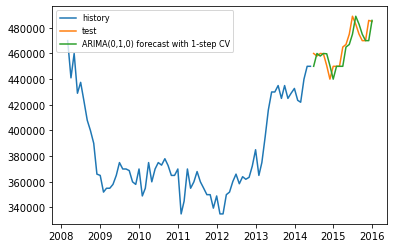

In [16]:
plt.plot(train, label='history')
plt.plot(test, label='test')
plt.plot(predictions_1step, label='ARIMA(0,1,0) forecast with 1-step CV')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [17]:
rmse_1

8161.607813737632